## Sentiment analysis for Customer satisfaction towards product 

#### Introduction

### Install packages

In [1]:
# install wordcloud package using pip in terminal
# upgrade pillow library in terminal

## Import libraries

In [68]:
# import the necessary libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk import FreqDist
from itertools import chain

from collections import Counter
from wordcloud import WordCloud

from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading data

In [3]:
# read the data

data = pd.read_csv('..\data\judge-1377884607_tweet_product_company.csv', encoding='latin-1')

data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
data.shape

(9093, 3)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Data cleaning

#### column names long and not intuitive, therefore rename the columns

In [6]:
# column names long and not intuitive, therefore rename the columns
data.rename({'tweet_text': 'tweet', 
             'emotion_in_tweet_is_directed_at': 'product_brand', 
             'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'}, 
             axis=1, inplace=True)

In [7]:
data.columns

Index(['tweet', 'product_brand', 'sentiment'], dtype='object')

#### Examine unique elements in each of the columns

In [8]:
# number of product brands
data.product_brand.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_brand, dtype: int64

In [9]:
# type of sentiment 
data.sentiment.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [10]:
# unique elements in the tweets
data.tweet.value_counts()

RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                             4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                             3
#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan    2
                                                                                                                                             ..
RT @mention Holla! RT @mention At google party. Best ever! Get your butt over here. #sxsw                                               

## Tweet column
#### tweets should be unique, however, some tweets have more than one count

#### duplicated values (there are 22 duplicated rows)


In [11]:
print(data.duplicated().sum())

22


In [12]:
# Find and display duplicate rows
duplicate_rows = data[data.duplicated()]
print(duplicate_rows)

                                                  tweet       product_brand  \
468      Before It Even Begins, Apple Wins #SXSW {link}               Apple   
776   Google to Launch Major New Social Network Call...                 NaN   
2232  Marissa Mayer: Google Will Connect the Digital...                 NaN   
2559  Counting down the days to #sxsw plus strong Ca...               Apple   
3950  Really enjoying the changes in Gowalla 3.0 for...         Android App   
3962  #SXSW is just starting, #CTIA is around the co...             Android   
4897  Oh. My. God. The #SXSW app for iPad is pure, u...  iPad or iPhone App   
5338  RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...                 NaN   
5341  RT @mention ÷¼ Happy Woman's Day! Make love, ...                 NaN   
5881  RT @mention Google to Launch Major New Social ...                 NaN   
5882  RT @mention Google to Launch Major New Social ...                 NaN   
5883  RT @mention Google to Launch Major New Social 

In [13]:
# sum the duplicate rows
len(duplicate_rows)

22

#### Tweets should be unique, remove duplicate rows based on the tweet column

In [14]:
# Removes duplicates based on tweet column only
data = data.drop_duplicates(subset=['tweet'])  
data.head()


,tweet,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [15]:
# explore data again for any duplicates
print(data.duplicated().sum())

0


### Product_brand column

In [16]:
# unique elements in the product_brand
data.product_brand.value_counts()

iPad                               943
Apple                              659
iPad or iPhone App                 469
Google                             428
iPhone                             296
Other Google product or service    293
Android App                         80
Android                             77
Other Apple product or service      35
Name: product_brand, dtype: int64

In [17]:
# unique elements in the product_brand
# there are 3291 rows with product_brand values
data.product_brand.value_counts().sum()

3280

In [18]:
data['product_brand'].isna().sum()

5786

In [19]:
# fill null rows of product_brand with unknowm
data['product_brand'].fillna('Unknown', inplace=True)
data.head()

,tweet,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [20]:
# check throught the data frame for any NaN values in product_brand
data['product_brand'].isna().sum()

0

In [21]:
# Print the value count of product_brand column
data.product_brand.value_counts()

Unknown                            5786
iPad                                943
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: product_brand, dtype: int64

### sentiment column

the values in the sentiment column can be made more intuitive

In [22]:
sentiment_dict = {'Positive emotion': 'Positive', 
                'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
data['sentiment'] = data['sentiment'].map(sentiment_dict)
data.head()

,tweet,product_brand,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


In [23]:
data['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [24]:
# check throught the data frame for any NaN values in sentiment
data['sentiment'].isna().sum()

0

#### Distribution of sentiment in bar graph

<function matplotlib.pyplot.show(close=None, block=None)>

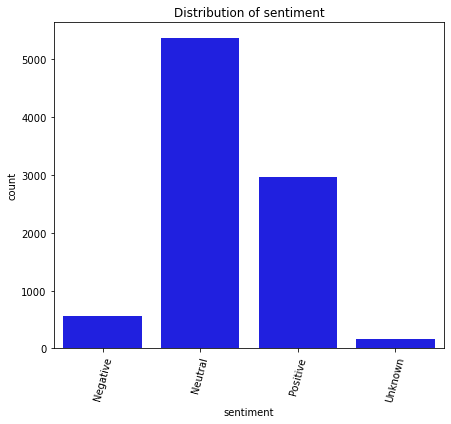

In [25]:
plt.figure(figsize=(7,6))
sns.countplot(x=data['sentiment'].sort_values(), color='Blue')
plt.title('Distribution of sentiment')
plt.xticks(rotation=75)
plt.show

Reviewing the emotions vs the product in use

Text(0.5, 1.0, 'Sentiment Vs Product_brand')

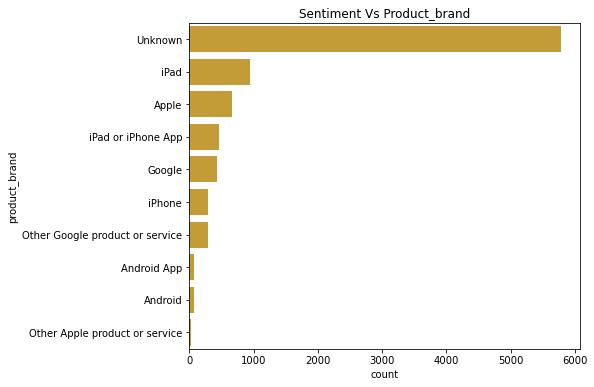

In [26]:
plt.figure(figsize=(7,6))
sns.countplot(y=data['product_brand'].sort_values(), order=data['product_brand'].value_counts().nlargest(10).index,
              color='goldenrod')
plt.title('Sentiment Vs Product_brand')


Sentiment distribution of each product_brand

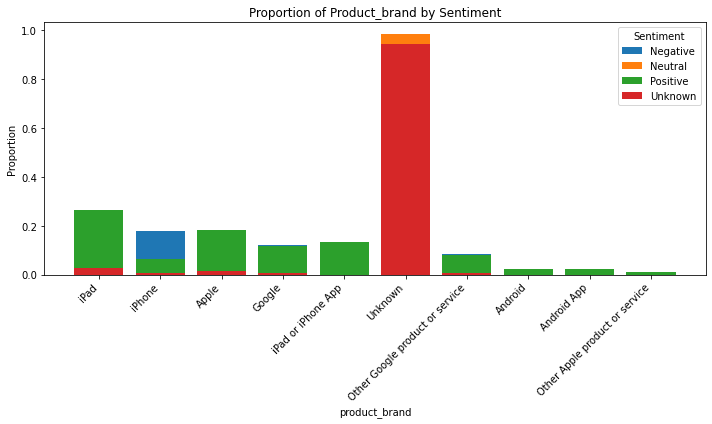

In [27]:
# Grouping by 'Sentiment' and calculating normalized value counts for 'product_brand'
grouped_data1 = data.groupby(['sentiment'])['product_brand'].value_counts(normalize=True)

# Convert the grouped data into a DataFrame for easier plotting
grouped_data1 = grouped_data1.reset_index(name='Proportion')

# Plotting the data
plt.figure(figsize=(10, 6))
for sentiment in grouped_data1['sentiment'].unique():
    subset = grouped_data1[grouped_data1['sentiment'] == sentiment]
    plt.bar(subset['product_brand'], subset['Proportion'], label=sentiment)

# Adding labels and title
plt.xlabel('product_brand')
plt.ylabel('Proportion')
plt.title('Proportion of Product_brand by Sentiment')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')

# Show plot
plt.tight_layout()
plt.show()


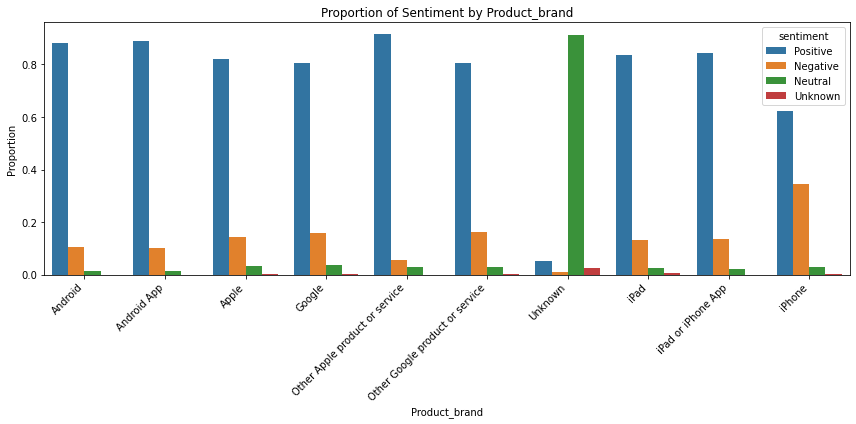

In [28]:
# Grouping by 'product_brand' and calculating normalized value counts for 'Sentiment'
grouped_data2 = data.groupby(['product_brand'])['sentiment'].value_counts(normalize=True)

# Convert the grouped data into a DataFrame for easier plotting
grouped_data2 = grouped_data2.reset_index(name='Proportion')

# Plotting the data using seaborn's barplot for better visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='product_brand', y='Proportion', hue='sentiment', data=grouped_data2)

# Adding labels and title
plt.xlabel('Product_brand')
plt.ylabel('Proportion')
plt.title('Proportion of Sentiment by Product_brand')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


In [29]:
# dataframe for preprocessing
pd.set_option("display.max_colwidth", 300)
data.head()

,tweet,product_brand,sentiment
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive


### Text cleaning

### Complete body of text

In [30]:
# generate a list all tweets
corpus_all = data['tweet'].to_list()
corpus_all

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd',
 nan,
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.l

In [31]:
# Create an intance of the RegexpTokenizer with the variable name `tokenizer`
# The regex pattern should select all words with three or more characters
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')

# Create a list of stopwords in English
stopwords_list = stopwords.words('english')

# Add custom stop words to stopwords i.e abbreviation and product/company names
custom_stopwords = ['#sxsw', '#sxswi', 'sxsw','link','rt', 
                    'ipad', 'ipad2', 'apple', 'google', 'iphone', '#apple',
                    '#google', '#ipad', '#iphone', 'android']
stopwords_list.extend(custom_stopwords)


# Create an instance of nltk's PorterStemmer with the variable name `stemmer`
stemmer = PorterStemmer()

#### Function That Implements Standard Text Preprocessing
The `preprocess_text` function returns lower cased, tokenized, stopwords removed, and stemmed text

In [32]:
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Handle missing values (if text is NaN or None)
    if not isinstance(text, str):
        return ''  # or return 'NaN', or skip based on your use case
    # Standardize case (lowercase the text)
    text = text.lower()
    # Tokenize text using `tokenizer`
    tokens = tokenizer.tokenize(text)
    # Remove stopwords using `stopwords_list`
    filtered_tokens = [words for words in tokens if words not in stopwords_list]
    # Stem the tokenized text using `stemmer` similar to lemmatization
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # Return the preprocessed text
    return stemmed_tokens
preprocess_text("", tokenizer, stopwords_list, stemmer)

[]

In [33]:
# text after preprocessing in a list
corpus_clean = [preprocess_text(x, tokenizer, stopwords_list, stemmer) for x in corpus_all]
corpus_clean


[['wesley83',
  'hr',
  'tweet',
  'rise_austin',
  'dead',
  'need',
  'upgrad',
  'plugin',
  'station'],
 ['jessede',
  'know',
  'fludapp',
  'awesom',
  'app',
  'like',
  'appreci',
  'design',
  'also',
  'give',
  'free'],
 ['swonderlin', 'wait', 'also', 'sale'],
 ['hope', 'year', 'festiv', 'crashi', 'year', 'app'],
 ['sxtxstate',
  'great',
  'stuff',
  'fri',
  'marissa',
  'mayer',
  'tim',
  'reilli',
  'tech',
  'book',
  'confer',
  'amp',
  'matt',
  'mullenweg',
  'wordpress'],
 ['teachntech00',
  'new',
  'app',
  'speechtherapi',
  'commun',
  'showcas',
  'confer',
  'http',
  '49n4m',
  'iear',
  'edchat',
  'asd'],
 '',
 ['start',
  'ctia',
  'around',
  'corner',
  'googleio',
  'hop',
  'skip',
  'jump',
  'good',
  'time',
  'fan'],
 ['beauti',
  'smart',
  'simpl',
  'idea',
  'madebymani',
  'thenextweb',
  'wrote',
  'hollergram',
  'app',
  'http',
  'bit',
  'ieavob'],
 ['count',
  'day',
  'plu',
  'strong',
  'canadian',
  'dollar',
  'mean',
  'stock',
 

#### Alternatively create a new column i.e processed_text in the dataframe

In [34]:
# (This may take a while due to nested loops)
data_text = data.tweet.apply(lambda x: preprocess_text(x, tokenizer, stopwords_list, stemmer))
data_text

0                                                [wesley83, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]
1                                         [jessede, know, fludapp, awesom, app, like, appreci, design, also, give, free]
2                                                                                         [swonderlin, wait, also, sale]
3                                                                                [hope, year, festiv, crashi, year, app]
4       [sxtxstate, great, stuff, fri, marissa, mayer, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]
                                                              ...                                                       
9088                                                                                                         [everywher]
9089                               [wave, buzz, mention, interrupt, regularli, schedul, geek, program, big, news, circl]
9090          [zeiger, physician

#### Dataframe that has the preprocessed tweets

In [35]:
# create a dataframe that has the preprocessed tweets
data["preprocessed_tweet"] = data_text
data.head()

,tweet,product_brand,sentiment,preprocessed_tweet
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative,"[wesley83, hr, tweet, rise_austin, dead, need, upgrad, plugin, station]"
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[jessede, know, fludapp, awesom, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[swonderlin, wait, also, sale]"
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative,"[hope, year, festiv, crashi, year, app]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,"[sxtxstate, great, stuff, fri, marissa, mayer, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"


### Exploratory Data Analysis

#### Most frequent words

In [36]:
# 'preprocessed_tweet' column contains lists of tokens (words) for each tweet
# Flatten the list of lists into a single list of tokens
all_words = list(chain(*data["preprocessed_tweet"]))

# Create frequency distribution
freq_text = FreqDist(all_words)

# Get 50 most common words
most_common_words = freq_text.most_common(50)
most_common_words


[('mention', 7116),
 ('quot', 1702),
 ('store', 1523),
 ('new', 1084),
 ('app', 1050),
 ('austin', 971),
 ('launch', 830),
 ('amp', 827),
 ('circl', 683),
 ('social', 664),
 ('pop', 612),
 ('today', 577),
 ('get', 537),
 ('open', 537),
 ('network', 481),
 ('line', 459),
 ('via', 436),
 ('parti', 407),
 ('call', 397),
 ('free', 388),
 ('mobil', 347),
 ('sxswi', 341),
 ('like', 332),
 ('come', 330),
 ('use', 323),
 ('one', 321),
 ('time', 316),
 ('win', 303),
 ('major', 302),
 ('check', 301),
 ('day', 284),
 ('map', 279),
 ('temporari', 265),
 ('see', 257),
 ('possibl', 252),
 ('need', 247),
 ('design', 240),
 ('look', 235),
 ('peopl', 231),
 ('make', 227),
 ('downtown', 224),
 ('great', 222),
 ('go', 220),
 ('popup', 212),
 ('mayer', 211),
 ('know', 203),
 ('set', 197),
 ('talk', 193),
 ('think', 191),
 ('show', 189)]

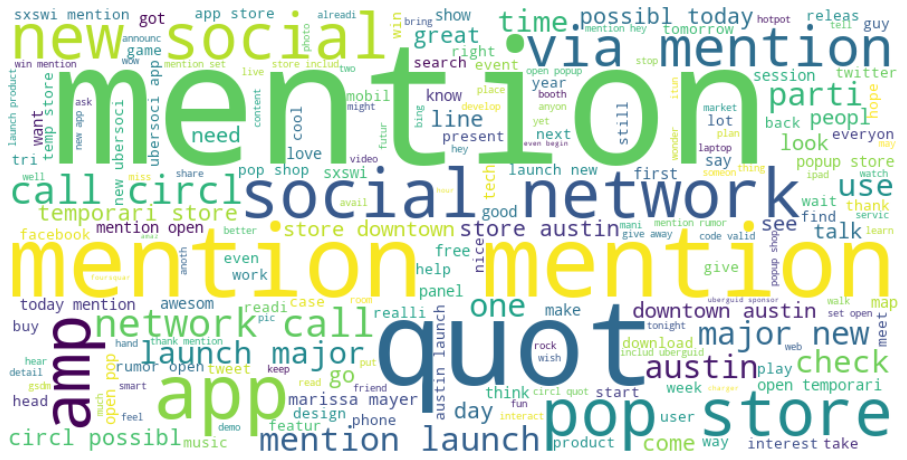

In [37]:
# Plot WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(16, 14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Common Bigrams
To extract bigrams (pairs of two consecutive words) from the text and calculate their frequency

In [38]:
# Initialize bigram measures
bigram_measures = BigramAssocMeasures()

# Initialize the BigramCollocationFinder with the list of tokens
bigram_finder = BigramCollocationFinder.from_words(all_words)

# Get frequency information for bigrams
bigrams = bigram_finder.score_ngrams(bigram_measures.raw_freq)

# Display the top 50 bigrams
top_50_bigrams = bigrams[:50]
top_50_bigrams

[(('mention', 'mention'), 0.014034098569625062),
 (('social', 'network'), 0.005638153137141947),
 (('pop', 'store'), 0.005393016044222732),
 (('new', 'social'), 0.005025310404843909),
 (('via', 'mention'), 0.004363440253962028),
 (('network', 'call'), 0.0039099366320614806),
 (('call', 'circl'), 0.003885422922769559),
 (('mention', 'launch'), 0.003836395504185716),
 (('major', 'new'), 0.0034932035740988148),
 (('launch', 'major'), 0.0033951487369311287),
 (('temporari', 'store'), 0.0029539019696765414),
 (('possibl', 'today'), 0.002855847132508856),
 (('circl', 'possibl'), 0.0028068197139250128),
 (('store', 'austin'), 0.00243911407454619),
 (('quot', 'mention'), 0.0023533160920244647),
 (('downtown', 'austin'), 0.0023165455280865824),
 (('mention', 'quot'), 0.002230747545564857),
 (('store', 'downtown'), 0.0021081789991052495),
 (('marissa', 'mayer'), 0.002083665289813328),
 (('open', 'pop'), 0.0018998124701239169),
 (('open', 'temporari'), 0.0018752987608319953),
 (('today', 'mention

### Divide the dataframe to three - positive, negative and neutral sentiment

In [39]:
positive_sentiment = data[data['sentiment'] == 'Positive']
negative_sentiment = data[data['sentiment'] == 'Negative']
neutral_sentiment = data[data['sentiment'] == 'Neutral']

In [40]:
data['sentiment'].value_counts()

Neutral     5373
Positive    2968
Negative     569
Unknown      156
Name: sentiment, dtype: int64

In [41]:
positive_sentiment.head()

,tweet,product_brand,sentiment,preprocessed_tweet
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive,"[jessede, know, fludapp, awesom, app, like, appreci, design, also, give, free]"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive,"[swonderlin, wait, also, sale]"
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive,"[sxtxstate, great, stuff, fri, marissa, mayer, tim, reilli, tech, book, confer, amp, matt, mullenweg, wordpress]"
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive,"[start, ctia, around, corner, googleio, hop, skip, jump, good, time, fan]"
8,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive,"[beauti, smart, simpl, idea, madebymani, thenextweb, wrote, hollergram, app, http, bit, ieavob]"


### Positive sentiment

In [42]:
# 'preprocessed_tweet' column contains lists of tokens (words) for each tweet
# Flatten the list of lists into a single list of tokens for positive sentiment
positive_words = list(chain(*positive_sentiment["preprocessed_tweet"]))

# Create frequency distribution
freq_positive_text = FreqDist(positive_words)

# Get 50 most common words
most_common_positive_words = freq_positive_text.most_common(50)
most_common_positive_words


[('mention', 2195),
 ('store', 559),
 ('app', 483),
 ('quot', 465),
 ('new', 360),
 ('austin', 295),
 ('pop', 217),
 ('get', 212),
 ('amp', 208),
 ('launch', 195),
 ('open', 183),
 ('parti', 154),
 ('one', 151),
 ('time', 146),
 ('line', 146),
 ('win', 145),
 ('come', 142),
 ('great', 137),
 ('use', 136),
 ('via', 132),
 ('social', 127),
 ('day', 125),
 ('free', 124),
 ('circl', 124),
 ('like', 122),
 ('map', 122),
 ('cool', 121),
 ('today', 114),
 ('love', 113),
 ('awesom', 105),
 ('check', 102),
 ('mobil', 101),
 ('sxswi', 97),
 ('good', 96),
 ('look', 94),
 ('network', 93),
 ('see', 92),
 ('temporari', 89),
 ('downtown', 88),
 ('thank', 88),
 ('peopl', 83),
 ('got', 81),
 ('popup', 77),
 ('make', 73),
 ('even', 72),
 ('call', 70),
 ('market', 69),
 ('want', 69),
 ('year', 69),
 ('mayer', 67)]

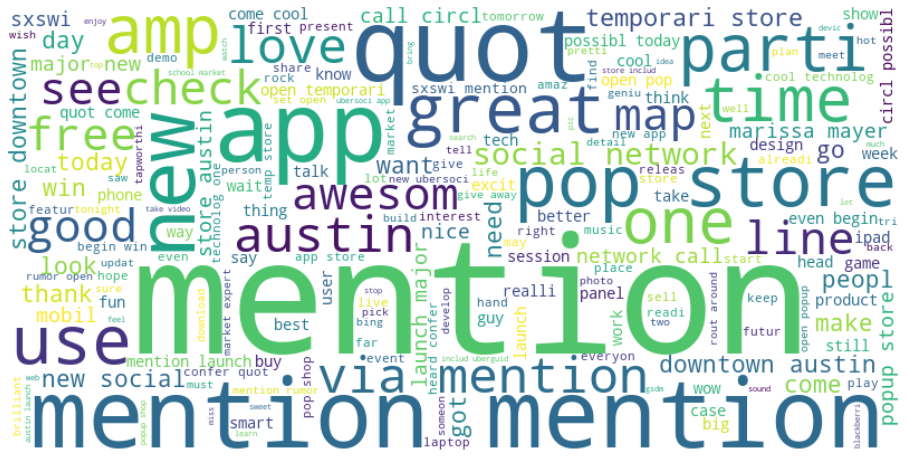

In [43]:
# Plot WordCloud for positive sentiment
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_words))
plt.figure(figsize=(16, 14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Bigram for positive sentiment

In [44]:
# Initialize bigram measures
bigram_measures = BigramAssocMeasures()

# Initialize the BigramCollocationFinder with the list of tokens
bigram_finder_pos = BigramCollocationFinder.from_words(positive_words)

# Get frequency information for bigrams
bigrams = bigram_finder_pos.score_ngrams(bigram_measures.raw_freq)

# Display the top 50 bigrams
top_50_pos_bigrams = bigrams[:50]
top_50_pos_bigrams

[(('mention', 'mention'), 0.011062112265490694),
 (('pop', 'store'), 0.005830032139920772),
 (('via', 'mention'), 0.004260408102249795),
 (('social', 'network'), 0.00321399207713581),
 (('temporari', 'store'), 0.0030645040735480977),
 (('new', 'social'), 0.0028776440690634576),
 (('mention', 'quot'), 0.0027655280663726736),
 (('downtown', 'austin'), 0.0026907840645788174),
 (('store', 'downtown'), 0.0025786680618880334),
 (('quot', 'mention'), 0.002204948052918753),
 (('call', 'circl'), 0.0021675760520218253),
 (('marissa', 'mayer'), 0.0021675760520218253),
 (('network', 'call'), 0.0021302040511248974),
 (('launch', 'major'), 0.002018088048434113),
 (('major', 'new'), 0.002018088048434113),
 (('popup', 'store'), 0.001980716047537185),
 (('store', 'austin'), 0.001980716047537185),
 (('open', 'temporari'), 0.001943344046640257),
 (('open', 'pop'), 0.0019059720457433292),
 (('mention', 'launch'), 0.001831228043949473),
 (('mention', 'new'), 0.001756484042155617),
 (('mention', 'app'), 0.0

### Negative sentiment

In [45]:
# 'preprocessed_tweet' column contains lists of tokens (words) for each tweet
# Flatten the list of lists into a single list of tokens for negative sentiment
negative_words = list(chain(*negative_sentiment["preprocessed_tweet"]))

# Create frequency distribution
freq_negative_text = FreqDist(negative_words)

# Get 50 most common words
most_common_negative_words = freq_negative_text.most_common(50)
most_common_negative_words


[('mention', 313),
 ('quot', 175),
 ('app', 90),
 ('store', 47),
 ('like', 44),
 ('new', 43),
 ('circl', 37),
 ('need', 35),
 ('get', 34),
 ('social', 31),
 ('design', 31),
 ('use', 31),
 ('launch', 31),
 ('peopl', 29),
 ('austin', 26),
 ('think', 24),
 ('look', 24),
 ('line', 23),
 ('one', 23),
 ('time', 23),
 ('amp', 22),
 ('day', 22),
 ('take', 22),
 ('call', 21),
 ('today', 21),
 ('say', 20),
 ('fail', 20),
 ('would', 19),
 ('come', 18),
 ('news', 18),
 ('pop', 18),
 ('network', 18),
 ('phone', 18),
 ('year', 17),
 ('headach', 17),
 ('batteri', 17),
 ('long', 17),
 ('product', 17),
 ('talk', 17),
 ('wait', 16),
 ('tweet', 15),
 ('user', 15),
 ('tri', 15),
 ('thing', 15),
 ('good', 15),
 ('see', 15),
 ('much', 15),
 ('compani', 15),
 ('america', 15),
 ('back', 14)]

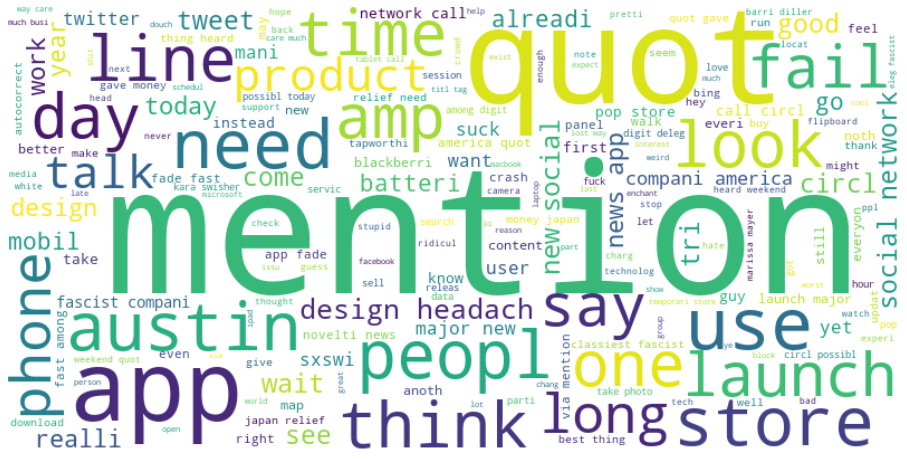

In [46]:
# Plot WordCloud for negative sentiment
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_words))
plt.figure(figsize=(16, 14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Bigram for negative sentiment

In [47]:
# Initialize bigram measures
bigram_measures = BigramAssocMeasures()

# Initialize the BigramCollocationFinder with the list of tokens
bigram_finder_neg = BigramCollocationFinder.from_words(negative_words)

# Get frequency information for bigrams
bigrams = bigram_finder_neg.score_ngrams(bigram_measures.raw_freq)

# Display the top 50 bigrams
top_50_neg_bigrams = bigrams[:50]
top_50_neg_bigrams

[(('mention', 'mention'), 0.00751597143930853),
 (('mention', 'quot'), 0.003945885005636978),
 (('design', 'headach'), 0.0031942878617061254),
 (('new', 'social'), 0.003006388575723412),
 (('social', 'network'), 0.002818489289740699),
 (('news', 'app'), 0.0026305900037579856),
 (('quot', 'mention'), 0.0026305900037579856),
 (('compani', 'america'), 0.0024426907177752723),
 (('fascist', 'compani'), 0.002254791431792559),
 (('major', 'new'), 0.002254791431792559),
 (('call', 'circl'), 0.002066892145809846),
 (('network', 'call'), 0.002066892145809846),
 (('pop', 'store'), 0.002066892145809846),
 (('quot', 'quot'), 0.002066892145809846),
 (('launch', 'major'), 0.0018789928598271326),
 (('app', 'fade'), 0.0016910935738444193),
 (('fade', 'fast'), 0.0016910935738444193),
 (('fast', 'among'), 0.0016910935738444193),
 (('novelti', 'news'), 0.0016910935738444193),
 (('via', 'mention'), 0.0016910935738444193),
 (('america', 'quot'), 0.001503194287861706),
 (('app', 'mention'), 0.001503194287861

### Neutral sentiment

In [48]:
# 'preprocessed_tweet' column contains lists of tokens (words) for each tweet
# Flatten the list of lists into a single list of tokens for negative sentiment
neutral_words = list(chain(*neutral_sentiment["preprocessed_tweet"]))

# Create frequency distribution
freq_neutral_text = FreqDist(neutral_words)

# Get 50 most common words
most_common_neutral_words = freq_neutral_text.most_common(50)
most_common_neutral_words


[('mention', 4504),
 ('quot', 1023),
 ('store', 895),
 ('new', 672),
 ('austin', 634),
 ('launch', 596),
 ('amp', 595),
 ('circl', 503),
 ('social', 494),
 ('app', 468),
 ('today', 434),
 ('pop', 367),
 ('network', 362),
 ('open', 340),
 ('call', 297),
 ('get', 286),
 ('via', 282),
 ('line', 281),
 ('free', 262),
 ('parti', 242),
 ('mobil', 232),
 ('sxswi', 229),
 ('major', 227),
 ('possibl', 191),
 ('check', 189),
 ('come', 169),
 ('temporari', 169),
 ('win', 154),
 ('like', 153),
 ('use', 151),
 ('see', 148),
 ('design', 147),
 ('make', 144),
 ('map', 143),
 ('time', 143),
 ('need', 141),
 ('one', 139),
 ('know', 136),
 ('downtown', 135),
 ('go', 135),
 ('mayer', 134),
 ('day', 133),
 ('popup', 132),
 ('talk', 129),
 ('set', 125),
 ('show', 122),
 ('marissa', 120),
 ('say', 115),
 ('look', 114),
 ('peopl', 114)]

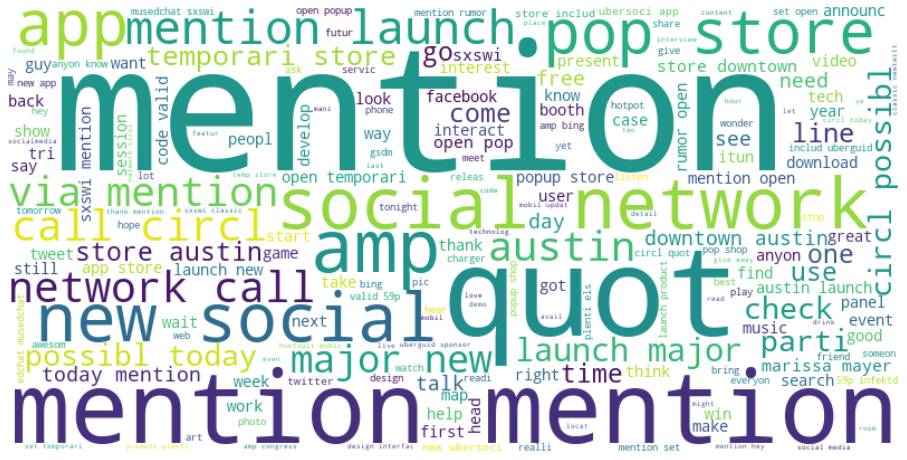

In [49]:
# Plot WordCloud for neutral sentiment
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(neutral_words))
plt.figure(figsize=(16, 14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Bigrams for Neutral sentiment

In [50]:
# Initialize bigram measures
bigram_measures = BigramAssocMeasures()

# Initialize the BigramCollocationFinder with the list of tokens
bigram_finder_neut = BigramCollocationFinder.from_words(neutral_words)

# Get frequency information for bigrams
bigrams = bigram_finder_neut.score_ngrams(bigram_measures.raw_freq)

# Display the top 50 bigrams
top_50_neut_bigrams = bigrams[:50]
top_50_neut_bigrams

[(('mention', 'mention'), 0.0162875246701984),
 (('social', 'network'), 0.007291991274540355),
 (('new', 'social'), 0.006481770021813649),
 (('pop', 'store'), 0.005526124441674457),
 (('mention', 'launch'), 0.005235275786849486),
 (('network', 'call'), 0.005089851459437),
 (('call', 'circl'), 0.005027526747688792),
 (('via', 'mention'), 0.004715903188947751),
 (('major', 'new'), 0.004528929053703126),
 (('launch', 'major'), 0.00440427963020671),
 (('possibl', 'today'), 0.003801807416640698),
 (('circl', 'possibl'), 0.003697932897060351),
 (('temporari', 'store'), 0.0031577853952425472),
 (('store', 'austin'), 0.002783837124753298),
 (('today', 'mention'), 0.002513763373844396),
 (('quot', 'mention'), 0.0024929884699283265),
 (('downtown', 'austin'), 0.002409888854264049),
 (('marissa', 'mayer'), 0.002202139815103355),
 (('store', 'downtown'), 0.0021190401994390777),
 (('open', 'pop'), 0.0020774903916069387),
 (('open', 'temporari'), 0.0020359405837748),
 (('mention', 'amp'), 0.00172431

### Feature Extraction

In [51]:
# Join preprocessed tokens back into a string for vectorization
data['preprocessed_tweet_str'] = data['preprocessed_tweet'].apply(lambda x: ' '.join(x))

In [52]:
# Create train test split
X_train, X_test, y_train, y_test = train_test_split(
    data["preprocessed_tweet_str"], data.sentiment, test_size=0.3)

X_train

3621                                                 mention stay away store tomorrow
415          read articl say rumor mention launch major new social network call circl
3688                                                         longest line store cours
8899                                  decid releas product art scienc mention mention
612       would thunk mention agenc push direct never would gone otherwis say mention
                                            ...                                      
148                      anyon chanc check pop store wonder worth trek convent center
7920        set 000 squar foot temporari store sell new ipad test potenti socialmedia
3907                     cant wait give samsung peopl demo horribl terribl nexu phone
715                                   part present good thing crash instead work best
2775    foursquar ûª extra special revamp fulli autom merchant platform denniscrowley
Name: preprocessed_tweet_str, Length: 6346, dtype: obj

In [53]:
X_test

3625                                wonder front camera back camera use ratio differ btwn
4973                                      ben think make fast aim product day one agileag
3571                            mention wish liveblog app amp wordpress plugin readi quit
3144                                             pollak much troubl sell duh sxswbigbrand
3559                   mention outdid time tech fail broken might worst thing ever happen
                                              ...                                        
6945                                    mention win soni xperia play phone tuesday detail
410                                                       could find mention probabl fite
4383                                     mention twitter app day head want tweet lot help
1670                              quot classiest fascist compani america quot say mention
3988    first book purchas new mention quot thank economi quot wait crushit afternoon tye
Name: prep

### Fit a Count Vectorizer

In [54]:
# Create a `vectorizer` instance
vectorizer = CountVectorizer()

# Fit the vectorizer to the training data
vectorizer.fit(X_train)

CountVectorizer()

### Vectorize the training and test datasets using the fitted count vectorizer

In [55]:

X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Fit a Decision Tree Model

Use an instance of `sklearn`'s `DecisionTreeClassifier` 
Fit the model to the vectorized training data

In [56]:
# Initialize `dt_classifier`
dt_classifier = DecisionTreeClassifier()

# Fit the model to the training data
dt_classifier.fit(X_train_vectorized, y_train)

DecisionTreeClassifier()

#### Model prediction

In [64]:
# Get the predictions from the decision tree classifier
y_pred_dt = dt_classifier.predict(X_test_vectorized)
y_pred_dt

array(['Neutral', 'Positive', 'Neutral', ..., 'Negative', 'Negative',
       'Neutral'], dtype=object)

#### Model evaluation

In [66]:
accuracy = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", accuracy)
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.6261029411764706
Classification Report (Decision Tree):
               precision    recall  f1-score   support

    Negative       0.38      0.25      0.30       176
     Neutral       0.71      0.73      0.72      1630
    Positive       0.51      0.54      0.53       867
     Unknown       0.07      0.04      0.05        47

    accuracy                           0.63      2720
   macro avg       0.42      0.39      0.40      2720
weighted avg       0.62      0.63      0.62      2720



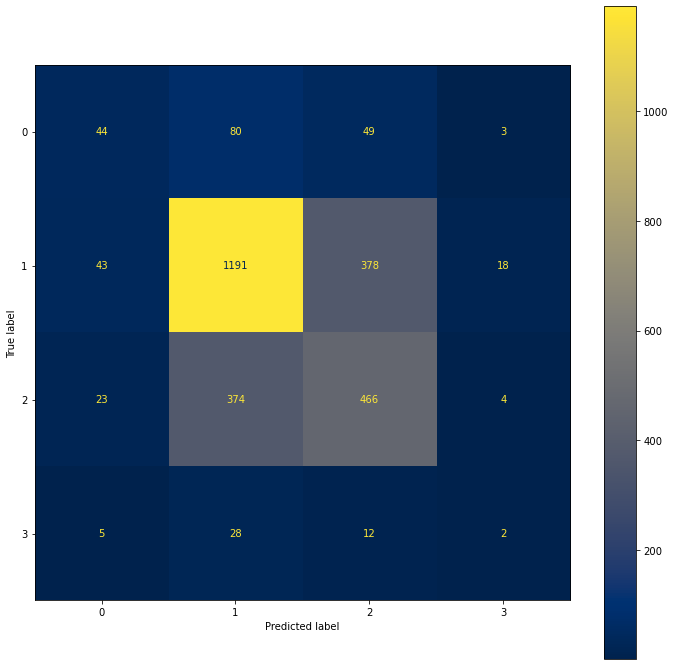

In [65]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_dt)
# Create the confusion matrix display
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Plot the confusion matrix with the chosen color map
disp.plot(ax=ax, cmap="cividis")
# Show the plot
plt.show()

#### Hyperparameter Tuning using GridSearchCV

In [69]:
# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],  # None means no limit on tree depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']  # None means considering all features
}

In [70]:
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           n_jobs=-1,  # Use all available processors
                           verbose=1,  # Show progress
                           scoring='accuracy')  # Optimize for accuracy

# Fit GridSearchCV on the training data
grid_search.fit(X_train_vectorized, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

In [71]:
# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


In [73]:
# 3. Evaluate the best model from GridSearchCV
best_model = grid_search.best_estimator_  # Get the model with the best parameters
y_pred_best = best_model.predict(X_test_vectorized)  # Predict on test data
y_pred_best

array(['Negative', 'Positive', 'Neutral', ..., 'Neutral', 'Negative',
       'Positive'], dtype=object)

In [74]:
# Model Evaluation
print("Tuned Decision Tree Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report (Tuned Decision Tree):\n", classification_report(y_test, y_pred_best))

Tuned Decision Tree Accuracy: 0.6334558823529411
Classification Report (Tuned Decision Tree):
               precision    recall  f1-score   support

    Negative       0.35      0.26      0.30       176
     Neutral       0.72      0.74      0.73      1630
    Positive       0.52      0.54      0.53       867
     Unknown       0.00      0.00      0.00        47

    accuracy                           0.63      2720
   macro avg       0.40      0.38      0.39      2720
weighted avg       0.62      0.63      0.63      2720



### Logistic regression model

In [59]:
# Logistic Regression Model
# fit the model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_vectorized, y_train)  # Train the model


c:\Users\salom\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [61]:
# Predict on test data
y_pred_logreg = logreg_model.predict(X_test_vectorized) 
y_pred_logreg 


array(['Neutral', 'Neutral', 'Positive', ..., 'Neutral', 'Negative',
       'Neutral'], dtype=object)

### Model Evaluation

In [67]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report (Logistic Regression):\n", classification_report(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.6841911764705882
Classification Report (Logistic Regression):
               precision    recall  f1-score   support

    Negative       0.53      0.24      0.33       176
     Neutral       0.72      0.83      0.77      1630
    Positive       0.61      0.54      0.57       867
     Unknown       0.20      0.02      0.04        47

    accuracy                           0.68      2720
   macro avg       0.51      0.41      0.43      2720
weighted avg       0.66      0.68      0.67      2720

